In [6]:
pip install osmnx


Note: you may need to restart the kernel to use updated packages.


In [14]:
import osmnx as ox
import networkx as nx
import math
import heapq
import json
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from google.colab import files
uploaded = files.upload()


ModuleNotFoundError: No module named 'google'

In [21]:
import pandas as pd

df = pd.read_csv("Data/abs-gps.csv")
print(df.head())  # Kontrol için ilk birkaç satırı gösterdim


     timestamp  abs-latitude  abs-longitude  abs-altitude
0  1203.094660     -0.001980       0.000376      0.208233
1  1203.594883     -0.002000       0.000376      0.208636
2  1204.094388     -0.002021       0.000377      0.208832
3  1204.590754     -0.002040       0.000378      0.208895
4  1205.091595     -0.002060       0.000381      0.208347


In [25]:
scale = 20
coordinates = list(zip(df['abs-latitude']*scale, df['abs-longitude']*scale))


Bulunan yol (node indexleri): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,

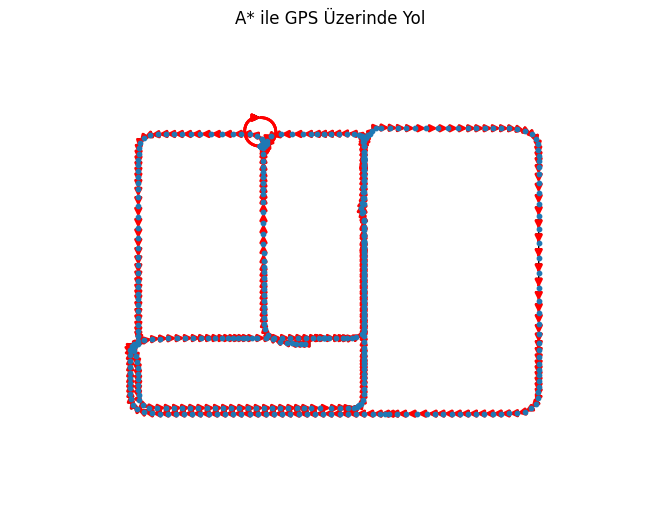

In [27]:

# 3. Haversine fonksiyonu (iki GPS noktası arası mesafe)
def haversine(coord1, coord2):
    R = 6371
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))

# 4. Grafik oluşturma (GPS noktaları düğüm, mesafe kenar uzunluğu)
G = nx.DiGraph()
for i, coord in enumerate(coordinates):
    G.add_node(i, pos=coord)

for i in range(len(coordinates) - 1):
    dist = haversine(coordinates[i], coordinates[i+1])
    G.add_edge(i, i+1, length=dist)

# 5. distance_heuristic fonksiyonu
def distance_heuristic(n1, n2, node_data):
    coord1 = node_data[n1]['pos']
    coord2 = node_data[n2]['pos']
    return haversine(coord1, coord2)

# 6. get_path fonksiyonu
def get_path(start, goal, predecessors):
    path = [goal]
    while path[-1] != start:
        path.append(predecessors[path[-1]])
    path.reverse()
    return path

# 7. A* algoritması
def a_star_search(origin_key, goal_key, graph):
    open_queue = []
    heapq.heappush(open_queue, (0, origin_key))
    closed_dict = {}
    predecessors = {}
    costs = {origin_key: 0.0}
    node_data = graph.nodes(True)

    goal_found = False
    while open_queue:
        f_cost, u = heapq.heappop(open_queue)

        if u == goal_key:
            goal_found = True
            break

        for edge in graph.out_edges([u], data=True):
            if edge[1] in closed_dict:
                continue

            length = edge[2]['length']
            g_cost = costs[u] + length
            h_cost = distance_heuristic(edge[1], goal_key, node_data)
            f_cost = g_cost + h_cost

            if edge[1] in costs:
                if g_cost < costs[edge[1]]:
                    costs[edge[1]] = g_cost
                    heapq.heappush(open_queue, (f_cost, edge[1]))
                    predecessors[edge[1]] = u
            else:
                costs[edge[1]] = g_cost
                heapq.heappush(open_queue, (f_cost, edge[1]))
                predecessors[edge[1]] = u

        closed_dict[u] = 0

    if not goal_found:
        raise ValueError("Goal not found in search.")

    return get_path(origin_key, goal_key, predecessors)

# 8. Başlangıç ve hedef node
start_node = 0
goal_node = len(coordinates) - 1

# 9. A*'ı çalıştır
path = a_star_search(start_node, goal_node, G)
print("Bulunan yol (node indexleri):", path)

# 10. Haritada göster
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size=10, with_labels=False)
path_edges = list(zip(path, path[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)
plt.title("A* ile GPS Üzerinde Yol")
plt.show()
